In [74]:
import torch
from torch import nn
from d2l import torch as d2l

In [75]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0, 0.5, (n_train, )) 
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

In [76]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat],xlabel='x', ylabel='y', 
        legend=['Truth', 'Pred'], xlim=[0,5],   ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha = 0.5);

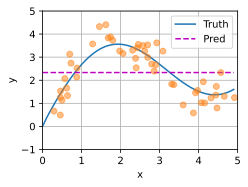

In [77]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

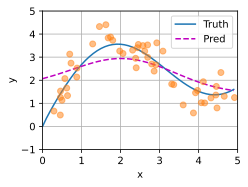

In [78]:
x_repeat = x_test.repeat_interleave(n_train).reshape(-1, n_train)

## x_repeat: n_test, n_train     attention_weights:  
attention_weights = nn.functional.softmax(-(x_repeat - x_train) ** 2 / 2,dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

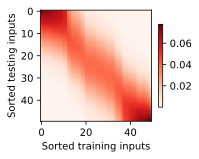

In [79]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                   ylabel='Sorted testing inputs' )

In [80]:
X = torch.ones([2, 1, 4])
Y = torch.ones([2, 4, 6])
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [81]:
weights =  torch.ones((2, 10)) * 0.1
values = torch.arange(20.).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))


tensor([[[ 4.5000]],

        [[14.5000]]])

In [82]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand(1, ), requires_grad=True)

    def forward(self, queries, keys, values):
        # queries 形状： 查询个数，key-values个数 ， 
        # 查询个数 ：类别个数|softmax输出个数， k—v个数 是一次训练数据个数
        queries = queries.repeat_interleave(keys.shape[1]).reshape(-1, keys.shape[1])
        # 所有的训练数据 需要和 每一个需要预测的数据|softmax的输出个数 进行核计算权重
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w) ** 2 / 2, dim=1) 
        # 输出形状   查询个数
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)


In [83]:
X_title = x_train.repeat((n_train, 1))
Y_title = y_train.repeat((n_train, 1))

X_title.shape, Y_title.shape

(torch.Size([50, 50]), torch.Size([50, 50]))

In [84]:
# n_train , 训练数据量
keys = X_title[(1 - torch.eye(n_train)).type(torch.bool)].reshape(n_train, -1)
values = Y_title[(1 - torch.eye(n_train)).type(torch.bool)].reshape(n_train, -1)
# 去掉 对角线, 每次训练 每行 和第i个元素是需要拟合的数据，其他数据是训练数据
keys.shape, values.shape

(torch.Size([50, 49]), torch.Size([50, 49]))

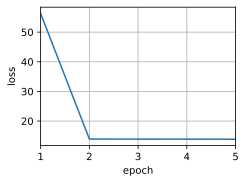

In [85]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch+1}, loss {l.sum():.6f}')
    animator.add(epoch + 1, float(l.sum()))

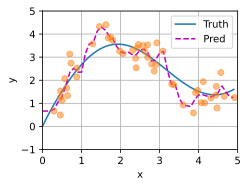

In [86]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))

y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

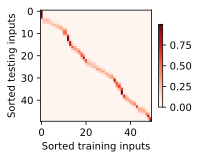

In [87]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')